<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/bert-gr-c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# load the data
balanced_corpus = pd.read_csv("data/balanced_corpus.csv", index_col=0)
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

In [2]:
from transformers import BertModel, BertTokenizer
model_name = 'nlpaueb/bert-base-greek-uncased-v1'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [3]:
import torch
from sklearn.preprocessing import OneHotEncoder

# the areas that will serve as target label indices
idx2loc = {i:a for i,a in enumerate(train.area.unique())}
loc2idx = {idx2loc[i]:i for i in idx2loc}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, max_length = 32):
        self.max_length = max_length
        self.labels = df.area.apply(lambda a: loc2idx[a])
        self.labels = np.array(self.labels.values)
        self.labels = np.reshape(self.labels, (self.labels.shape[0], 1))
        self.labels = OneHotEncoder(sparse_output=False).fit_transform(self.labels)
        self.texts = np.array(df.text.apply(lambda txt: tokenizer(txt, padding='max_length', max_length = self.max_length, truncation=True, return_tensors="pt")).values)

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        batch_texts = self.texts[idx]
        batch_labels = self.labels[idx]
        return batch_texts, batch_labels

In [4]:
from torch import nn

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.1, num_classes=1):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 128, bias=True)
        self.norm = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128, num_classes, bias=True)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        x = pooled_output
        x = self.dropout(x)
        x = self.relu(self.linear1(x))
        x = self.norm(x)
        x = self.linear2(x)
        return x

In [5]:
from torch.optim import Adam
from tqdm import tqdm

def validate(model, dataloader, device="cpu", criterion=nn.CrossEntropyLoss()):
    predictions, gold_labels = [], []
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_id, (val_input, val_label) in enumerate(dataloader):
            val_label = val_label.to(device)
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            batch_loss = criterion(output, val_label)
            gold = np.argmax(val_label.cpu().detach().numpy(), axis=1)
            pred = np.argmax(output.cpu().detach().numpy(), axis=1)
            predictions.extend(pred)
            gold_labels.extend(gold)
            val_loss += batch_loss.item()
    return predictions, gold_labels, val_loss/batch_id

def finetune(model, train_data, val_data, learning_rate=2e-5, epochs=10, criterion=nn.CrossEntropyLoss(), 
             batch_size=32, max_length=32, patience=2):
    
    train_losses = []
    val_losses = []
    
    train_dataloader = torch.utils.data.DataLoader(Dataset(train_data, max_length=max_length), 
                                                   batch_size=batch_size, shuffle=True, drop_last=False)
    val_dataloader = torch.utils.data.DataLoader(Dataset(val_data, max_length=max_length), 
                                                 batch_size=batch_size, drop_last=False)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    optimizer = Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    lowest_loss = 10
    best_epoch = 0
    epochs_not_improving = 0
    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            for batch_id, (inputs, labels) in tqdm(enumerate(train_dataloader)):
                model.train()
                output = model(inputs['input_ids'].squeeze(1).to(device), 
                               inputs['attention_mask'].to(device))
                batch_loss = criterion(output.to(device), labels.to(device))
                total_loss_train += batch_loss.item()

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()
            train_losses.append(total_loss_train/(batch_id+1))
            
            predictions, gold_labels, val_loss = validate(model, val_dataloader, device, criterion)
            val_losses.append(val_loss)
            if val_loss < lowest_loss:
                print(f"New best epoch found: {epoch_num} (val loss: {val_loss:.3f})!")
                lowest_loss = val_loss
                best_epoch = epoch_num
                torch.save(model.state_dict(), "checkpoint.pt")
                epochs_not_improving = 0
            else:
                epochs_not_improving += 1
                if epochs_not_improving >= patience:
                    model.load_state_dict(torch.load("checkpoint.pt"))
                    print('Patience is up, restoring the best model and exiting...')
                    break
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/batch_id: .3f} \
                | Val Loss: {val_loss: .3f} (best epoch: {best_epoch} w/val_loss: {lowest_loss:.3f})')
    model.eval()    
    return model, train_losses, val_losses

In [6]:
model, train_losses, val_losses = finetune(BertClassifier(num_classes=len(loc2idx)), 
                                           train, dev, 
                                           epochs=100, 
                                           patience=5, 
                                           batch_size=64, 
                                           max_length=16)

Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
162it [00:09, 16.85it/s]


New best epoch found: 0 (val loss: 3.384)!
Epochs: 1 | Train Loss:  3.225                 | Val Loss:  3.384 (best epoch: 0 w/val_loss: 3.384)


162it [00:09, 17.63it/s]


New best epoch found: 1 (val loss: 3.181)!
Epochs: 2 | Train Loss:  2.989                 | Val Loss:  3.181 (best epoch: 1 w/val_loss: 3.181)


162it [00:09, 17.42it/s]


New best epoch found: 2 (val loss: 3.100)!
Epochs: 3 | Train Loss:  2.803                 | Val Loss:  3.100 (best epoch: 2 w/val_loss: 3.100)


162it [00:09, 17.38it/s]


New best epoch found: 3 (val loss: 3.040)!
Epochs: 4 | Train Loss:  2.679                 | Val Loss:  3.040 (best epoch: 3 w/val_loss: 3.040)


162it [00:09, 17.32it/s]


New best epoch found: 4 (val loss: 2.960)!
Epochs: 5 | Train Loss:  2.556                 | Val Loss:  2.960 (best epoch: 4 w/val_loss: 2.960)


162it [00:09, 17.31it/s]


New best epoch found: 5 (val loss: 2.920)!
Epochs: 6 | Train Loss:  2.425                 | Val Loss:  2.920 (best epoch: 5 w/val_loss: 2.920)


162it [00:09, 17.30it/s]


New best epoch found: 6 (val loss: 2.916)!
Epochs: 7 | Train Loss:  2.286                 | Val Loss:  2.916 (best epoch: 6 w/val_loss: 2.916)


162it [00:09, 17.29it/s]


Epochs: 8 | Train Loss:  2.127                 | Val Loss:  2.933 (best epoch: 6 w/val_loss: 2.916)


162it [00:09, 17.26it/s]


Epochs: 9 | Train Loss:  1.954                 | Val Loss:  2.961 (best epoch: 6 w/val_loss: 2.916)


162it [00:09, 17.24it/s]


Epochs: 10 | Train Loss:  1.740                 | Val Loss:  3.009 (best epoch: 6 w/val_loss: 2.916)


162it [00:09, 17.22it/s]


Epochs: 11 | Train Loss:  1.526                 | Val Loss:  3.012 (best epoch: 6 w/val_loss: 2.916)


162it [00:09, 17.22it/s]


Patience is up, restoring the best model and exiting...


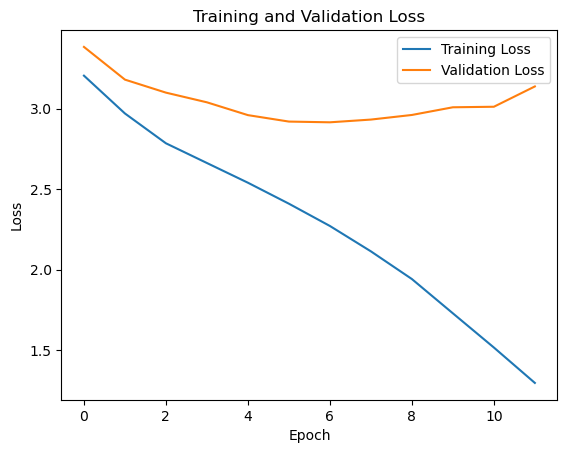

In [7]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [8]:
test_dataloader = torch.utils.data.DataLoader(Dataset(test), batch_size=1, drop_last=False)
p,l,_ = validate(model.to("cpu"), test_dataloader, "cpu")
print(classification_report([idx2loc[i] for i in l], [idx2loc[i] for i in p]))

                 precision    recall  f1-score   support

        Ήπειρος       0.00      0.00      0.00        23
        Αιτωλία       0.37      0.58      0.45        24
        Αμοργός       0.18      0.32      0.23        22
Ανατολική Θράκη       0.12      0.33      0.17        24
        Αρκαδία       0.13      0.16      0.14        31
          Αχαΐα       0.40      0.53      0.46        32
      Επτάνησος       0.26      0.30      0.28        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.07      0.09      0.08        22
          Θράκη       0.00      0.00      0.00        25
       Ιωάννινα       0.24      0.14      0.17        29
       Κάρπαθος       0.55      0.21      0.31        28
     Κεφαλληνία       0.15      0.26      0.19        27
          Κρήτη       0.29      0.20      0.24        30
         Κύπρος       0.76      0.79      0.78        24
         Λέσβος       0.56      0.42      0.48        24
        Λακωνία       0.17    

In [9]:
torch.save(model.state_dict(), "bert-gr-c.pt")

In [10]:
model = BertClassifier(num_classes=len(loc2idx))
model.load_state_dict(torch.load("bert-gr-c.pt"))

Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>